<a href="https://colab.research.google.com/github/JonathonLeiding/fifa-score-analysis/blob/main/fifa_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Model(nn.Module):
  def __init__(self, in_features=43, h1=128, h2=64, h3=32, out_features=2):
        super().__init__()

        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)

  def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      return self.out(x)


In [3]:
url = 'https://raw.githubusercontent.com/JonathonLeiding/fifa-score-analysis/refs/heads/main/jup_notebooks/cleaned_prem_data.csv'
df = pd.read_csv(url)

In [4]:
df.head(2)

,player_id,fifa_version,overall,potential,age,height_cm,weight_kg,club_team_id,club_jersey_number,preferred_foot,...,body_type_Lean (170-),body_type_Lean (170-185),body_type_Lean (185+),body_type_Normal (170-),body_type_Normal (170-185),body_type_Normal (185+),body_type_Stocky (170-),body_type_Stocky (170-185),body_type_Stocky (185+),body_type_Unique
0,653,23,91.0,91.0,1.335393,-0.193612,-0.786092,6,17.0,Right,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,29,23,90.0,90.0,2.658522,0.656983,0.892630,7,7.0,Right,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
player_ids = torch.tensor(df['player_id'].values, dtype=torch.long)
club_ids = torch.tensor(df['club_team_id'].values, dtype=torch.long)

df = df[df['pace'].notna()]


df = df.drop(['primary_position', 'player_id', 'club_team_id'], axis=1)
df['preferred_foot'] = df['preferred_foot'].map({'Right': 0, 'Left': 1})

In [6]:
X_train = df[df['fifa_version'] < 22].drop(['fifa_version', 'goals','assists'], axis=1)
X_train = torch.FloatTensor(X_train.values)

X_test = df[df['fifa_version'] >= 22].drop(['fifa_version', 'goals','assists'], axis=1)
X_test = torch.FloatTensor(X_test.values)


In [7]:
Y_train = df[df['fifa_version'] < 22]
Y_train = Y_train[['goals','assists']]
Y_train = torch.FloatTensor(Y_train.values)

Y_test = df[df['fifa_version'] >= 22]
Y_test = Y_test[['goals','assists']]
Y_test = torch.FloatTensor(Y_test.values)

In [8]:
# Pick a seed for randomization
torch.manual_seed(31)
# Create an instance of a Model
model = Model()

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.SmoothL1Loss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.60)

In [10]:
losses = []
epochs = 1000
for i in range(0,epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred, Y_train)
  losses.append(loss.detach().cpu().numpy())

  if (i%10 == 0) | (i == epochs-1):
    print(f'epoch: {i}  loss: {loss}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()

epoch: 0  loss: 1.111159086227417
epoch: 10  loss: 0.9953371286392212
epoch: 20  loss: 0.9557724595069885
epoch: 30  loss: 0.9352694153785706
epoch: 40  loss: 0.9176600575447083
epoch: 50  loss: 0.9009395241737366
epoch: 60  loss: 0.8872541189193726
epoch: 70  loss: 0.8732349872589111
epoch: 80  loss: 0.8623160123825073
epoch: 90  loss: 0.8463705778121948
epoch: 100  loss: 0.8329301476478577
epoch: 110  loss: 0.8238252401351929
epoch: 120  loss: 0.8143618702888489
epoch: 130  loss: 0.8050074577331543
epoch: 140  loss: 0.7950748801231384
epoch: 150  loss: 0.7893385887145996
epoch: 160  loss: 0.7802584171295166
epoch: 170  loss: 0.7733431458473206
epoch: 180  loss: 0.7666758894920349
epoch: 190  loss: 0.7633687257766724
epoch: 200  loss: 0.7571744322776794
epoch: 210  loss: 0.7526695728302002
epoch: 220  loss: 0.7496755123138428
epoch: 230  loss: 0.7466524839401245
epoch: 240  loss: 0.7437715530395508
epoch: 250  loss: 0.7410503625869751
epoch: 260  loss: 0.7384123802185059
epoch: 270  l

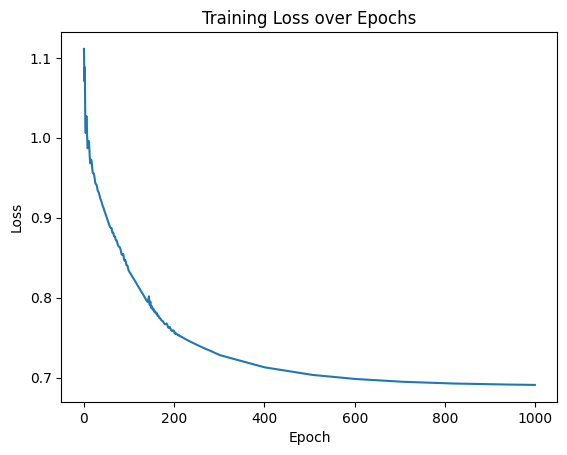

In [11]:
# Graph the loss
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training Loss over Epochs")
plt.show()

In [14]:
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, Y_test)

print(f"\nTest Loss: {test_loss.item():.4f}")



Test Loss: 0.8609
